# 1. 데이터 로드
사전에 은하의 ID로 동일하게 indexing 된 5개의 데이터 로드

In [1]:
import numpy as np
from scipy import stats
from scipy.stats import norm

import os.path
import pymfits as fits

import matplotlib.pyplot as plt
import matplotlib
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import AxesGrid
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)

from astropy.table import Table
from astropy.cosmology import WMAP7

%matplotlib inline
matplotlib.rc('font', family='AppleGothic')
plt.rc('font',  family='AppleGothic')
plt.rcParams['axes.unicode_minus']=False

# 1.Spectroscopy
mpa_emi = fits.mrdfits('../SpecGalaxy_MPA_MATCHED_EMISSION.fits', 1) #'SN_MEDIAN'
mpa_emi_ew = fits.mrdfits('../SpecGalaxy_MPA_MATCHED_EQW.fits', 1) # EMISSION LINES'S EW
#mpa = fits.mrdfits('../SpecGalaxy_MPA_MATCHED.fits', 1)
#ossy = fits.mrdfits('../SpecGalaxy_OSSY_MATCHED.fits', 1)

# 2.Magnitude #K-corrected
data = fits.mrdfits('../SpecGalaxy_final_v2_err.fits', 1) #PETROMAG UGRIZ, PETROMAGerror, MODELMAG UGRIZ, VMAX

# 3.UV, NUV&FUV mag #K-corrected
galex = fits.mrdfits('../SpecGalaxy_GALEX_KCORRECTED.fits', 1) #SDSSID, GALEXID, RA, DEC, Z, NUV_R, NUV_MAG, NUV_MAGERR, FUV_MAG, FUV_MAGERROR, E_BV, MATCHED, ALLDATA, ONLYNUV, ONLYFUV, SEPARATION

# 4.Original Magnitude #Not K-corrected
#phot = fits.mrdfits('../SpecGalaxy_phot.fits', 1)   #BESTOBJID, PETROMAG UGRIZ, PETROMAGerror, EXTINCTION UGRIZ

# 5.Morp, Galxy Zoo
morp = fits.mrdfits('../SpecGalaxy_GZ_MATCHED.fits', 1)#OBJID, 'RA','DEC','MORP_GZ', GZMATCHED

# 6.Stellar Mass
#mendel = fits.mrdfits('../SpecGalaxy_MENDEL_MATCHED.fits', 1)

# 7.size, structure
#struct = fits.mrdfits('../SpecGalaxy_Struct_MATCHED.fits', 1)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width: 90% !important; }</style>"))

def shiftedColorMap(cmap, start=0, midpoint=0.5, stop=1.0, name='shiftedcmap'):
    #https://stackoverflow.com/questions/7404116/defining-the-midpoint-of-a-colormap-in-matplotlib
    '''
    Function to offset the "center" of a colormap. Useful for
    data with a negative min and positive max and you want the
    middle of the colormap's dynamic range to be at zero.

    Input
    -----
      cmap : The matplotlib colormap to be altered
      start : Offset from lowest point in the colormap's range.
          Defaults to 0.0 (no lower offset). Should be between
          0.0 and `midpoint`.
      midpoint : The new center of the colormap. Defaults to 
          0.5 (no shift). Should be between 0.0 and 1.0. In
          general, this should be  1 - vmax / (vmax + abs(vmin))
          For example if your data range from -15.0 to +5.0 and
          you want the center of the colormap at 0.0, `midpoint`
          should be set to  1 - 5/(5 + 15)) or 0.75
      stop : Offset from highest point in the colormap's range.
          Defaults to 1.0 (no upper offset). Should be between
          `midpoint` and 1.0.
    '''
    cdict = {'red': [],'green': [],'blue': [],'alpha': []}
    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)
    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0.0, midpoint, 128, endpoint=False), 
        np.linspace(midpoint, 1.0, 129, endpoint=True)])
    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)
        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))
    newcmap = matplotlib.colors.LinearSegmentedColormap(name, cdict)
    plt.register_cmap(cmap=newcmap)
    return newcmap

#  tick label size
mpl.rcParams['xtick.labelsize'] = 18
mpl.rcParams['ytick.labelsize'] = 18

# 2. 데이터 추출
### 5개의 데이터에서 조건을 만족하는 데이터를 추출

### 도구:  Numpy
#### Why Numpy?
- Numpy was faster than Pandas in all operations but was specially optimized when querying.
- https://towardsdatascience.com/speed-testing-pandas-vs-numpy-ffbf80070ee7

In [2]:
###############################################################
# 1) 'Peek&Graves 2.2 Galaxy Selection Criteria'
# => Remove low-S/N spectra (S/N < 5Å−1)
###############################################################
w = np.where(mpa_emi['SN_MEDIAN']>=5)
data, galex, morp, mpa_emi, mpa_emi_ew = data[w], galex[w], morp[w], mpa_emi[w], mpa_emi_ew[w] 
print(len(mpa_emi))
###############################################################
# 2) (galex['alldata'] == NUV, FUV 존재) & (morp['morp_gz'] == ETG)& 
#       & morp['gzmatched'] == 1 mpa_emi['MATCHED']==1, galex['MATCHED'] =1, 
# elements = ['CN2', 'CA4227','CA4455', 'HB', 'MG2', 'MGB', 'FE5270', 'FE5335’] 에 대하여 -10<lick<10
# galex['nuv_mag']>-100
#(galex['fov_radius'] < 0.6)
#& (mpa_emi['V_DISPEFF']>=0))
###############################################################
w = np.where((morp['morp_gz'] == 1) &((galex['onlyNUV'] == 1)| (galex['alldata'] == 1))) #(galex['onlyNUV'] == 1)
data, galex, morp, mpa_emi, mpa_emi_ew = data[w], galex[w], morp[w], mpa_emi[w], mpa_emi_ew[w] 
print(len(data))

w = np.where((morp['gzmatched'] == 1) & (mpa_emi['MATCHED']==1))
data, galex, morp, mpa_emi, mpa_emi_ew = data[w], galex[w], morp[w], mpa_emi[w], mpa_emi_ew[w] 
print(len(data))

w = np.where( (mpa_emi['LICK_CN2'] > -10) & (mpa_emi['LICK_CA4227'] > -10) & (mpa_emi['LICK_CA4455'] > -10) & (mpa_emi['LICK_HB'] > -10) & (mpa_emi['LICK_MG2'] > -10) & (mpa_emi['LICK_MGB'] > -10) & (mpa_emi['LICK_FE5270'] > -10)& (mpa_emi['LICK_FE5335'] > -10))
data, galex, morp, mpa_emi, mpa_emi_ew = data[w], galex[w], morp[w], mpa_emi[w], mpa_emi_ew[w] 
print(len(data))

w = np.where((mpa_emi['LICK_CN2'] < 10) & (mpa_emi['LICK_CA4227'] <10) & (mpa_emi['LICK_CA4455'] <10) & (mpa_emi['LICK_HB'] <10) & (mpa_emi['LICK_MG2'] <10) & (mpa_emi['LICK_MGB'] <10) & (mpa_emi['LICK_FE5270'] <10)& (mpa_emi['LICK_FE5335'] <10))
data, galex, morp, mpa_emi, mpa_emi_ew = data[w], galex[w], morp[w], mpa_emi[w], mpa_emi_ew[w] 
print(len(data))

w = np.where((np.log10(mpa_emi['V_DISPEFF'])>=1.4) & (np.log10(mpa_emi['V_DISPEFF'])<=2.8))
data, galex, morp, mpa_emi, mpa_emi_ew = data[w], galex[w], morp[w], mpa_emi[w], mpa_emi_ew[w] 
print(len(data))

678251
12209
12209
11607
11602
11404


<ipython-input-2-e6177448148d>:32: RuntimeWarning: invalid value encountered in log10
  w = np.where((np.log10(mpa_emi['V_DISPEFF'])>=1.4) & (np.log10(mpa_emi['V_DISPEFF'])<=2.8))


# 3. 데이터 전처리
# 3-1. 이상치 처리 1: $|X_{err}| <= \mu \pm 3 \sigma$

In [3]:
# ###############################################################
# #3) 'Lick Error <= 3 Sigma Galaxies
# ###############################################################
elements = ['CN2', 'CA4227','CA4455', 'HB', 'MG2', 'MGB', 'FE5270', 'FE5335']
for i in range(len(elements)):
    n = 'LICK_' + elements[i] 
    en = n + '_ERR'
    y = mpa_emi[n] #Lick
    yerr = mpa_emi[en]        
    w = np.where(np.abs(yerr) <= (np.mean(yerr) + 3*np.std(yerr)))
    data, galex, morp, mpa_emi, mpa_emi_ew = data[w], galex[w], morp[w], mpa_emi[w], mpa_emi_ew[w] 

print('After data cleaning 1st method', len(data))

After data cleaning 1st method 10826


# 3-2. 이상치 처리 2
## 데이터 단위 변환: Å으로 통일
## Error propagation: $X_{err}$, $<Fe>_{err}$ => $|\frac{X}{<Fe>}_{err}|$
## 이상치 처리: $|\frac{X}{<Fe>}_{err}|$ <= \mu \pm 3 

In [4]:
def y_unit_change_to_Angstrom(y, xname):
    cn2_dlamb = 4178.375 - 4143.375   # [Anstrom]
    mg2_dlamb = 5196.625 - 5154.125 
    if xname == 'CN2':
        delta_lambda = cn2_dlamb 
    if xname == 'MG2':
        delta_lambda = mg2_dlamb 
    y_new = delta_lambda * (1-10**(y/(-2.5))) #[A]
    return y_new

def yerr_unit_change_to_Angstrom(y, yerr, xname):
    cn2_dlamb = 4178.375 - 4143.375   # [Anstrom]
    mg2_dlamb = 5196.625 - 5154.125 
    if xname == 'CN2':
        delta_lambda = cn2_dlamb 
    if xname == 'MG2':
        delta_lambda = mg2_dlamb 
    a = delta_lambda
    b = (-1)/(2.5)
    yerr_new = b* np.log(10) *(-a * 10**(b*y)) * yerr # Exponential function
    return yerr_new

In [5]:
# ###############################################################
# #4)'Lick/<Fe> Error <= 3 Sigma Galaxies
# ###############################################################
elements = ['CN2', 'CA4227','CA4455', 'HB', 'MG2', 'MGB', 'FE5270', 'FE5335']

for i in range(len(elements)):
    n = 'LICK_' + elements[i] 
    en = n + '_ERR'
    y = mpa_emi[n] #Lick
    yerr = mpa_emi[en]
    #############################
    # 데이터 단위 변환 [Angstrom]
    if elements[i] == 'CN2':
        y = y_unit_change_to_Angstrom(y, 'CN2')
        yerr = yerr_unit_change_to_Angstrom(y, yerr, 'CN2')
    if elements[i] == 'MG2':
        y = y_unit_change_to_Angstrom(y, 'MG2')
        yerr = yerr_unit_change_to_Angstrom(y, yerr, 'MG2')
        
    # Error propagation of feature ratio
    meanFe  = (mpa_emi['LICK_FE5270']+ mpa_emi['LICK_FE5335']) / 2
    meanFe_err = np.sqrt((mpa_emi['LICK_FE5270_ERR']**2 + mpa_emi['LICK_FE5335_ERR']**2)/2)
    yerr_a_Fe = np.abs((y / meanFe)) * np.sqrt( (yerr/y)**2 + (meanFe_err/meanFe)**2)
    
    # 이상치 처리: Lick/<Fe> Error > 3 Sigma 인 데이터 제외
    w = np.where(np.abs(yerr_a_Fe) <= (np.mean(yerr_a_Fe) + 3*np.std(yerr_a_Fe)))
    data, galex, morp, mpa_emi, mpa_emi_ew = data[w], galex[w], morp[w], mpa_emi[w], mpa_emi_ew[w] 

print('After data cleaning 2nd method', len(data))

After data cleaning 2nd method 10100


# 3-3. 이상치 처리 3

### 선행 연구의 demarcation curve를 사용한 이상치의 index 계산
Kauffmann et al. 2003 <br>
- 신호대잡음비(signal-to-noise ratio)가 3 이하인 데이터(S/N <=3) 중
- AGN hosting galaxies 3127개의 index 계산 

# of 4 emission line S/N> 3 galaxies  1097
# total sample  10100
# s/n >3 sample  1097
# Star Forming galaxies  172
# AGN hosting galaxies  925
확인된 SF 은하 개수  172
제거할 AGN 은하 개수  925


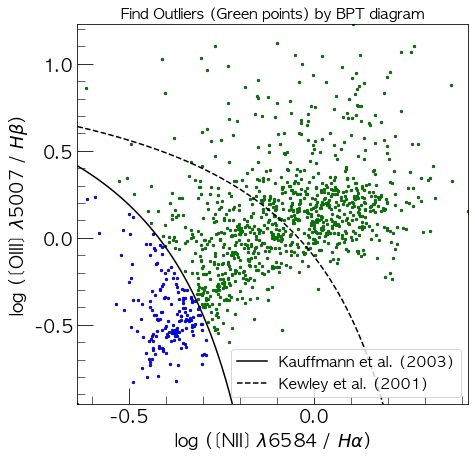

In [6]:
###############################################################
# 5) BPT diagram
###############################################################
data_sf, galex_sf, morp_sf, mpa_emi_sf, mpa_emi_ew_sf = data, galex, morp, mpa_emi, mpa_emi_ew
###############################################################
# 5-1) Kauffmann et al. 2003에 따라, 4 emission line의 S/N가 3 이하인 data를 제거
###############################################################
names = ['SN_OIII_5007', 'SN_H_BETA', 'SN_NII_6584', 'SN_H_ALPHA']
for n in names:
    w = np.where(mpa_emi_sf[n]>3)
    data_sf, galex_sf, morp_sf, mpa_emi_sf, mpa_emi_ew_sf = data_sf[w], galex_sf[w], morp_sf[w], mpa_emi_sf[w], mpa_emi_ew_sf[w] 
print('# of 4 emission line S/N> 3 galaxies ', len(mpa_emi_sf))

bpt_x = np.log10(mpa_emi_sf['NII_6584']/mpa_emi_sf['H_ALPHA'])
bpt_y = np.log10(mpa_emi_sf['OIII_5007']/mpa_emi_sf['H_BETA'])
############################################################
# 5-2) Among S/N > 3 samples find agn index
# Demarcation_curve
############################################################
ycurve_sf = 0.61/(bpt_x - 0.05) + 1.3 # Kauffmann et al. 2003

# y 값이 demarc line 이하에 위치한 데이터들의 index
sfidx = []
for i in range(len(bpt_y)):
    if bpt_y[i] <= ycurve_sf[i]:
        if bpt_x[i]<0:
            sfidx.append(i)
            
# y 값이 demarc line 초과에 위치한 데이터들의 index
agnidx = []
for i in range(len(bpt_y)):
    if i in sfidx:        continue
    else:        agnidx.append(i)
        
bpt_x_dem_sf = bpt_x[sfidx] # x-axis values of Star-forming sample at BPT diagram
bpt_y_dem_sf = bpt_y[sfidx] # y-axis values of Star-forming sample at BPT diagram
################################
# Select AGN candiated Sample
################################
bpt_x_dem_agn = np.delete(bpt_x, sfidx) # x-axis values of AGN sample at BPT diagram
bpt_y_dem_agn = np.delete(bpt_y, sfidx) # y-axis values of AGN sample at BPT diagram

print('# total sample ', len(data))
print('# s/n >3 sample ', len(data_sf))
print('# Star Forming galaxies ', len(bpt_x_dem_sf))
print('# AGN hosting galaxies ', len(bpt_x_dem_agn))

# ###############################################################
# 5-3) Among total S/N > 3 index, 
# A/B < demarc line 기준을 만족하는 은하의 index를 찾아서 total에 적용할 index에서 제거해준다.
# ###############################################################
#w # idx 1 : total 중에서 S/N > 3 index 495
#agnidx #idx 2 : S/N > 3 index중에서 agn index 407 / sf index 88

# idx1에서 idx2 번째에 있는 원소들을 제거해준다. new_a = np.delete(a, index)
agnidx = w[0][agnidx]
sfidx = w[0][sfidx]
print('확인된 SF 은하 개수 ', len(sfidx))
print('제거할 AGN 은하 개수 ', len(agnidx))

################################
# 5-4) Plot BPT diagram
################################
f = plt.figure(figsize=(7, 7))
ax_scatter = plt.axes()
xname = 'log ([NII] ' + r'$\lambda$' + '6584 / ' + r'$H\alpha$)'
yname = 'log ([OIII] ' + r'$\lambda$' + '5007 / ' + r'$H\beta$)'

# Data points
plt.scatter(bpt_x, bpt_y, c='k', s=5, alpha=0.7)
plt.scatter(bpt_x_dem_sf, bpt_y_dem_sf, c='b', s=5, alpha=0.7)
plt.scatter(bpt_x_dem_agn, bpt_y_dem_agn, c='g', s=5, alpha=0.7)

# Demarcation_curve
x = np.arange(np.min(bpt_x), -0.01, 0.01)
demarcation_curve_sf = 0.61/(x - 0.05) + 1.3  # Kauffmann et al. 2003
demarcation_curve_agn = 0.61/(np.arange(np.min(bpt_x), 0.2, 0.01) - 0.47) + 1.19  #Kewley et al. 2001
plt.plot(x, demarcation_curve_sf, c='k', label='Kauffmann et al. (2003)')
plt.plot(np.arange(np.min(bpt_x), 0.2, 0.01), demarcation_curve_agn, c='k',linestyle='--', label='Kewley et al. (2001) ')

plt.xlim(np.min(bpt_x), np.max(bpt_x))
plt.ylim(np.min(bpt_y), np.max(bpt_y))
plt.xlabel(xname, fontsize=18)
plt.ylabel(yname, fontsize=18)
ax_scatter.xaxis.set_major_formatter(FormatStrFormatter('%0.1f'))
ax_scatter.yaxis.set_major_formatter(FormatStrFormatter('%0.1f'))
ax_scatter.yaxis.set_major_locator(MultipleLocator(0.5))
ax_scatter.xaxis.set_major_locator(MultipleLocator(0.5))
ax_scatter.yaxis.set_minor_locator(MultipleLocator(0.1))
ax_scatter.tick_params(which='minor', length=8, direction = 'in')
ax_scatter.tick_params(which='major', length=16, direction = 'in')   
ax_scatter.xaxis.set_major_formatter(FormatStrFormatter('%0.1f'))
ax_scatter.xaxis.set_minor_locator(MultipleLocator(0.1))
ax_scatter.tick_params(which='minor', length=8, direction = 'in')
ax_scatter.tick_params(which='major', length=16, direction = 'in') 

plt.legend(prop={'size': 15})
plt.title('Find Outliers (Green points) by BPT diagram', fontsize=15)
# plt.savefig('/Users/dasolyoo/Desktop/MyResearch/Final_Figures_new/BPT_OnlyNUV_and_alldata.png')
plt.show()
plt.close()

# 4. 분석용 데이터 생성

In [7]:
data_ori, galex_ori, morp_ori, mpa_emi_ori, mpa_emi_ew_ori = np.delete(data,agnidx), np.delete(galex, agnidx), np.delete(morp, agnidx), np.delete(mpa_emi, agnidx), np.delete(mpa_emi_ew, agnidx) 
redshit_phot_ori = data_ori['Z']
lumdist_ori = WMAP7.luminosity_distance(data_ori['z']).value #[Mpc] Komatsu et al. 2011: H0 = 70.4, Om= 0.272, Flat =Yes
Mr_ori = data_ori['petromag_r'] - 5.0 * np.log10(lumdist_ori*1e6) + 5.0
print('After data cleaning 3rd method', len(data_ori))

After data cleaning 3rd method 9175


# 5. 잠재원인 도출
### 📌 인사이트1) 젊은 별의 영향을 많이 받으면 변수들의 세기가 감소하며, 변수마다 감소의 정도가 다르다.
### 📌 인사이트2) 마그네슘 함량 지표는 변수의 비율로 정의되어있으므로, 분자와 분모가 젋은 별의 영향을 받아 감소한 정도가 다르다면 비율이 감소할 가능성이 있다.

### 즉, 젊은 별의 영향으로 마그네슘 함량 지표인, $Mgb/<Fe>$와 $Mg2/<Fe>$가 감소할 가능성이 있다.
예를 들어, 

젊은 별의 영향이 커질수록 Mgb는 0.39베 Mg2는 0.507베 감소하지만, $<Fe>$는 0.126 감소한다. <br>

따라서 젊은 별의 영향을 받으면 이들의 비율인 $Mgb/<Fe>$와 $Mg2/<Fe>$가 감소할 것이다.

In [8]:
nuv_r = galex_ori['NUV_MAG'] - data_ori['MODELMAG_R'] # 기존 지표
hbeta = mpa_emi_ori['LICK_HB'] # 새로운 지표

Pearson 상관 분석 결과 NUV-r(근자외선 세기)와 $CN_2$은
상관계수가 0.48, p-value가 0.0이므로 양의 상관관계를 가진다.


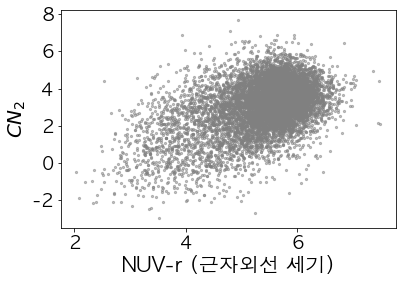

Pearson 상관 분석 결과 NUV-r(근자외선 세기)와 Ca4227은
상관계수가 0.272, p-value가 0.0이므로 양의 상관관계를 가진다.


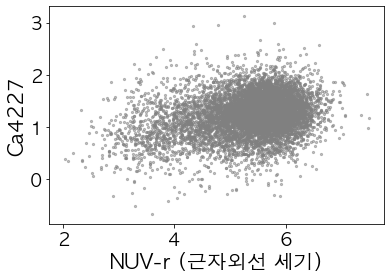

Pearson 상관 분석 결과 NUV-r(근자외선 세기)와 Ca4455은
상관계수가 0.167, p-value가 0.0이므로 양의 상관관계를 가진다.


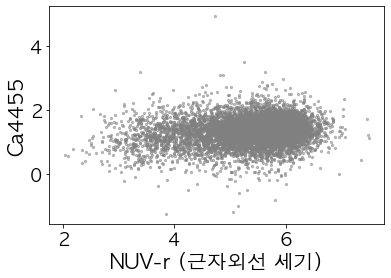

Pearson 상관 분석 결과 NUV-r(근자외선 세기)와 $Mg_2$은
상관계수가 0.507, p-value가 0.0이므로 양의 상관관계를 가진다.


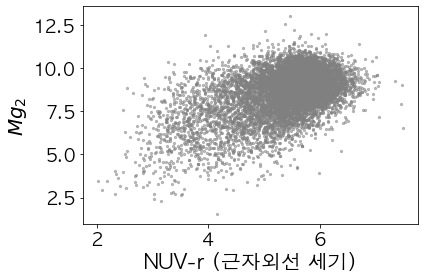

Pearson 상관 분석 결과 NUV-r(근자외선 세기)와 $Mgb$은
상관계수가 0.39, p-value가 0.0이므로 양의 상관관계를 가진다.


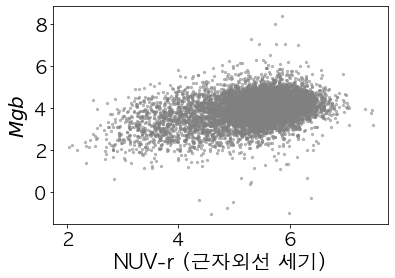

Pearson 상관 분석 결과 NUV-r(근자외선 세기)와 Fe5270은
상관계수가 0.136, p-value가 0.0이므로 양의 상관관계를 가진다.


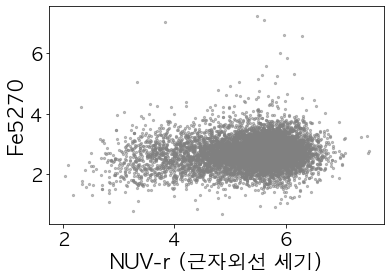

Pearson 상관 분석 결과 NUV-r(근자외선 세기)와 Fe5335은
상관계수가 0.057, p-value가 0.0이므로 양의 상관관계를 가진다.


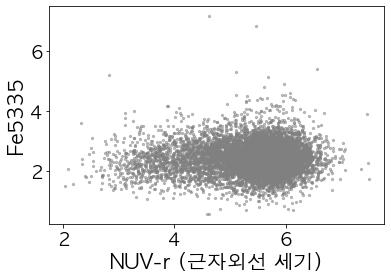

Pearson 상관 분석 결과 NUV-r(근자외선 세기)와 <Fe>은
상관계수가 0.126, p-value가 0.0이므로 양의 상관관계를 가진다.


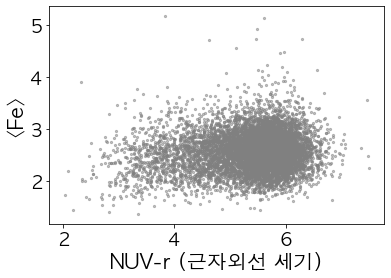

In [23]:
elements = ['CN2', 'CA4227','CA4455', 'MG2', 'MGB', 'FE5270', 'FE5335', '<Fe>']
ylabels = ['$CN_2$', 'Ca4227','Ca4455', '$Mg_2$', '$Mgb$', 'Fe5270', 'Fe5335', '<Fe>']
fs=20
#############################
for i in range(len(elements)):
    if elements[i] == '<Fe>':
        yn = ylabels[i]
        y = (mpa_emi_ori['LICK_FE5270']+mpa_emi_ori['LICK_FE5335'])/2
    else:
        n = 'LICK_' + elements[i] 
        yn = ylabels[i]
        y = mpa_emi_ori[n]
        #  데이터 단위 변환 [Angstrom]
        if elements[i] == 'CN2':
            y = y_unit_change_to_Angstrom(y, 'CN2')  
        if elements[i] == 'MG2':
            y = y_unit_change_to_Angstrom(y, 'MG2')
   
    corr, p = stats.pearsonr(nuv_r, y)
    print('Pearson 상관 분석 결과 NUV-r(근자외선 세기)와 '+yn+'은')
    print('상관계수가 {}, p-value가 {}이므로 양의 상관관계를 가진다.'.format(corr.round(3),p.round(3)))

    plt.scatter(nuv_r, y, c='grey', s=20, marker='.',alpha=0.5)
    plt.xlabel('NUV-r (근자외선 세기)', fontsize=fs)
    plt.ylabel(yn, fontsize=fs)
    plt.show()
    plt.close()